# Práctica Calificada 2 - Grupo 1
---
<h3>1. Objetivo</h3>

**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

<h3>2. Paquetes y librerías</h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt

%matplotlib inline

<h3>3. Dataset</h3>

El conjunto de datos está compuesto por un archivo CSV que contiene alrededor de 55
millones de registros de viajes en taxi. Cada registro contiene la siguiente información:
* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

**Población**

In [2]:
%%time
#df = pd.read_csv("train.csv") # approx 55M 
df = pd.read_csv("1M_train.csv") # Felipe trabaja con 1M, debido que su PC no es capaz de cargar los 55M :/ 


CPU times: user 15.6 s, sys: 1.26 s, total: 16.8 s
Wall time: 16.9 s


In [3]:
df.shape

(11085893, 8)

In [4]:
%%time
#predictors = ['distance']
salida = 'fare_amount'

y = df[salida]
X = df.drop(salida, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

#apartir de aqui no se toca el (X_test , y_test) hasta la evaluacion final

(7760125, 7)
(3325768, 7)
(7760125,)
(3325768,)
CPU times: user 5 s, sys: 215 ms, total: 5.21 s
Wall time: 5.21 s


In [5]:
data_train = pd.concat([X_train, y_train], axis=1) 
data_train.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6059663,2014-01-02 22:15:23.0000001,2014-01-02 22:15:23 UTC,-73.995074,40.750275,-74.003813,40.682850,1,21.50
991073,2013-03-11 08:19:00.000000131,2013-03-11 08:19:00 UTC,-73.866585,40.770880,-73.983335,40.758915,3,42.83
4601459,2014-01-09 09:09:41.0000001,2014-01-09 09:09:41 UTC,-73.977677,40.753350,-73.980462,40.765514,1,8.00
5233714,2014-12-27 21:27:00.00000044,2014-12-27 21:27:00 UTC,-73.976075,40.751820,-73.982302,40.739647,5,6.00
10899276,2011-08-08 05:27:00.0000001,2011-08-08 05:27:00 UTC,-73.992277,40.756010,-73.974787,40.762737,2,5.70


**Muestra**

In [30]:
%%time
df_s = data_train.sample(1000000, random_state = 7)

CPU times: user 703 ms, sys: 83.9 ms, total: 787 ms
Wall time: 794 ms


In [31]:
df_s.shape

(1000000, 8)

In [32]:
df_s.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
8629560,2009-05-31 13:24:00.00000023,2009-05-31 13:24:00 UTC,-73.954417,40.781387,-73.954960,40.780477,1,2.9
9814241,2011-08-16 07:55:49.0000002,2011-08-16 07:55:49 UTC,-73.963967,40.776743,-73.981969,40.751229,1,8.5
5712633,2011-04-08 06:38:54.0000003,2011-04-08 06:38:54 UTC,-73.982130,40.679015,-73.994197,40.673050,2,4.9
6151332,2013-11-28 16:10:00.00000022,2013-11-28 16:10:00 UTC,-73.978390,40.752820,-73.983250,40.739970,2,7.5
3857245,2013-01-09 20:40:08.0000005,2013-01-09 20:40:08 UTC,-73.975750,40.789618,-73.981740,40.763725,1,8.5


In [33]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 8629560 to 1298814
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   pickup_datetime    1000000 non-null  object 
 2   pickup_longitude   1000000 non-null  float64
 3   pickup_latitude    1000000 non-null  float64
 4   dropoff_longitude  999992 non-null   float64
 5   dropoff_latitude   999992 non-null   float64
 6   passenger_count    1000000 non-null  int64  
 7   fare_amount        1000000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 68.7+ MB


<h3>4. Limpieza de Datos</h3>

**ELIMINAR NA**

In [34]:
df_s.isna().sum()
# pandas.DataFrame.isna() vs pandas.DataFrame.isnull()
# These two DataFrame methods do exactly the same thing! 

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    8
dropoff_latitude     8
passenger_count      0
fare_amount          0
dtype: int64

In [35]:
df_s.dropna(inplace=True)

In [36]:
df_s.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
fare_amount          0
dtype: int64

In [37]:
df_s.shape

(999992, 8)

**NÚMERO DE PASAJEROS**

Descripción de la columna número de pasajeros (**passenger_count**)

In [38]:
df_s.passenger_count.describe()

count    999992.000000
mean          1.683351
std           1.322654
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

Visualizando **la cantidad de viajes en taxi por el número de pasajeros**

Text(0.5, 1.0, 'Cantidad de viajes en taxi por número de pasajeros')

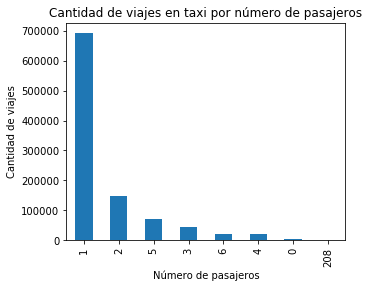

In [39]:
df_s["passenger_count"].value_counts().plot(kind="bar", figsize=(5, 4))
plt.xlabel("Número de pasajeros")
plt.ylabel("Cantidad de viajes")
plt.title("Cantidad de viajes en taxi por número de pasajeros")

Filtramos :  $ ~~0\leq \text{passenger_count}<8$

In [40]:
df_s["passenger_count"].between(0,6).value_counts() # Return boolean Series equivalent to left <= series <= right.

True     999991
False         1
Name: passenger_count, dtype: int64

**TARIFA DEL VIAJE**

Descripción de la columna monto de la tarifa (**fare_amount**)

In [41]:
df_s.fare_amount.describe()

count    999992.000000
mean         11.330624
std           9.740258
min        -100.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         563.040000
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$')

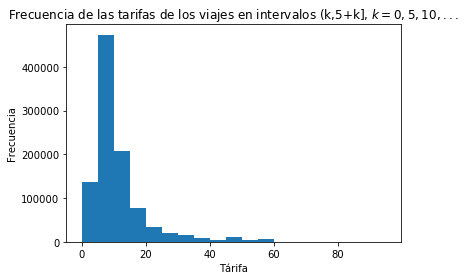

In [42]:
df_s["fare_amount"].plot.hist(alpha=1, stacked=True, bins=list(range(0, 100, 5)))
plt.xlabel("Tárifa")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$")

Filtramos :  $~~2\leq \text{fare_amount}\leq 200$

In [43]:
df_s[(df_s['fare_amount'] < 0)].shape # negativos

(51, 8)

In [44]:
df_s[(df_s['fare_amount'] > 0) & (df_s['fare_amount'] < 2)].shape # entre 0 y 2

(19, 8)

In [45]:
df_s[(df_s['fare_amount'] > 200)].shape # mayores de 200

(30, 8)

In [46]:
df_s["fare_amount"].between(2,200).value_counts()

True     999863
False       129
Name: fare_amount, dtype: int64

In [47]:
%%time
def filter_data(dataframe):
    #Solo quedan si cumplen las condiciones 
    return dataframe[
        #Coordenadas Ilegales
        (-180.0 <= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= 180.0)&
        (-90.0 <= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= 90.0)&
        (-180.0 <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= 180.0)&
        (-90.0 <= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= 90.0)&
        #Fare amount  
        (2.0 <= dataframe["fare_amount"])&
        (dataframe["fare_amount"] <= 200)&
        # passenger_count
        (1<=dataframe["passenger_count"])&
        (dataframe["passenger_count"]<= 6)]    
     
print ("Shape antes: ", df_s.shape)
data = filter_data(df_s)
print ("Shape despues: ", data.shape)
data["fare_amount"].between(2,200).value_counts()


Shape antes:  (999992, 8)
Shape despues:  (999992, 8)
CPU times: user 149 ms, sys: 94 µs, total: 149 ms
Wall time: 149 ms


True     999863
False       129
Name: fare_amount, dtype: int64

Shape despues:  (996339, 8)


True    996339
Name: fare_amount, dtype: int64

In [51]:
def swap_coordinates (dataframe,
    city_limits = { 
        "lon_min":-76,
        "lon_max":-73,
        "lat_min":38,
        "lat_max":50} ):
    #Intercambia las coordenadas de los viajes en 
    # la region [38 , 50]x[-76, -73]
    # la region de principarl de trabajo
    # (cuidad de NY) es : [-76, -73]x[38 , 50]
    datap = dataframe
    city_interchange = (
        (datap["pickup_longitude"] > city_limits["lat_min"])&
        (datap["pickup_longitude"] < city_limits["lat_max"])&
        (datap["pickup_latitude"] > city_limits["lon_min"] )& #-74.252444 
        (datap["pickup_latitude"] < city_limits["lon_max"] )& 

        (datap["dropoff_longitude"] > city_limits["lat_min"])&
        (datap["dropoff_longitude"] < city_limits["lat_max"])&
        (datap["dropoff_latitude"] >  city_limits["lon_min"] )&
        (datap["dropoff_latitude"] <  city_limits["lon_max"] ) 
        )
    print ( "Numero de reflejos : ",city_interchange.sum())
    
    datap.loc[city_interchange] = datap.loc[city_interchange].rename(columns={
        'pickup_longitude':'pickup_latitude',
        'pickup_latitude':'pickup_longitude',
        'dropoff_latitude':'dropoff_longitude',
        'dropoff_longitude':'dropoff_latitude'})
    return datap

df_s = swap_coordinates(df_s)


Numero de reflejos :  0


In [60]:
%%time
def filter_out_of_city(dataframe,city_limits = { 
        "lon_min":-74.252444 ,
        "lon_max":-73.629885,
        "lat_min":40.497175,
        "lat_max":40.825076}):
    #Solo quedan si estan dentro de la ciudad 
    return dataframe[
        (city_limits["lon_min"]<= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= city_limits["lat_max"])&
        (city_limits["lon_min"] <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= city_limits["lat_max"])]
     
print ("Shape antes: ", data.shape)
data = filter_out_of_city(data)
print ("Shape despues: ", data.shape)


Shape antes:  (996339, 8)
Shape despues:  (962031, 8)
CPU times: user 142 ms, sys: 36 ms, total: 178 ms
Wall time: 178 ms


In [28]:
# Se trabajará con la siguiente data:
# Region: New York
# 
#data = df_s[
#    (-74.252444 <= df_s["pickup_longitude"]) & 
#    (df_s["pickup_longitude"] <= -73.629885) &
#    (40.497175 <= df_s["pickup_latitude"]) &
#    (df_s["pickup_latitude"] <= 40.825076) & 
#    (-74.252444 <= df_s["dropoff_longitude"])&
#    (df_s["dropoff_longitude"] <= -73.629885) &
#    (40.497175 <= df_s["dropoff_latitude"]) &
#    (df_s["dropoff_latitude"] <= 40.825076)&
#    (2.0 <= df_s["fare_amount"]) & (df_s["fare_amount"] <= 200) & 
#    (0.0 < df_s["passenger_count"]) & (df_s["passenger_count"] <= 6) &
#    (df_s["pickup_longitude"] != df_s["dropoff_longitude"])]



In [53]:
%%time
data ['pickup_datetime'] = pd.to_datetime(data.pickup_datetime) # convertimos a tipo de dato de datetime
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour
data['weekday'] = data['pickup_datetime'].dt.weekday

data.drop(columns='key', inplace=True)
data.drop(columns='pickup_datetime', inplace=True)

print ( "Nuevo Shape:" , data.shape())

data.head(5)

KeyboardInterrupt: 

In [17]:
#def create_date_colums (dataframe):
#    dataframe['pickup_datetime'] = pd.to_datetime(dataframe.pickup_datetime) # convertimos a tipo de dato de datetime
#    dataframe['year'] = dataframe['pickup_datetime'].dt.year
#    dataframe['month'] = dataframe['pickup_datetime'].dt.month
#    dataframe['day'] = dataframe['pickup_datetime'].dt.day
#    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
#    dataframe['weekday'] = dataframe['pickup_datetime'].dt.weekday
#    #dropeamos la informacion redundante
#    dataframe.drop(columns='key', inplace=True)
#    dataframe.drop(columns='pickup_datetime', inplace=True)
#

In [23]:
df_s.shape


(996339, 8)

In [ ]:
data.describe()

In [13]:
data.shape

(951943, 12)

In [54]:
data.sort_values(by='pickup_longitude', ascending=False).tail(5)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
6849107,2011-08-10 19:27:00.00000072,2011-08-10 19:27:00 UTC,-83.732978,51.190717,-83.737645,51.191033,3,4.1
7732467,2010-09-25 21:00:20.0000001,2010-09-25 21:00:20 UTC,-83.809465,39.753707,-83.849971,39.647032,4,8.1
9183745,2013-10-28 22:29:13.0000001,2013-10-28 22:29:13 UTC,-88.259219,33.445460,-73.972255,40.782098,4,30.0
377901,2012-02-08 12:43:00.00000033,2012-02-08 12:43:00 UTC,-90.433333,40.773917,-73.954077,40.766490,1,5.3
11041755,2012-06-29 10:50:00.000000165,2012-06-29 10:50:00 UTC,-92.200000,40.773120,-73.959880,40.763700,1,7.3


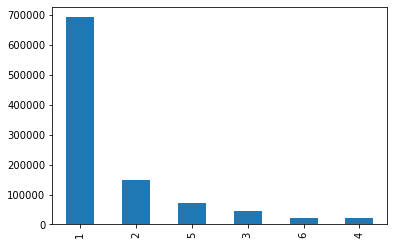

In [55]:
data["passenger_count"].value_counts().plot(kind="bar")

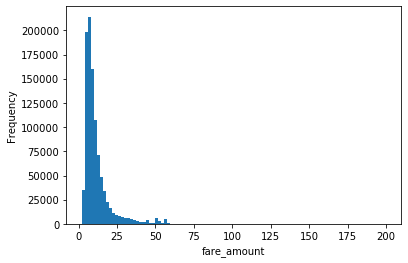

In [56]:
plt.xlabel("fare_amount")
data["fare_amount"].plot.hist(alpha=1, stacked=True, bins=100)

/home/jesus/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jesus/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


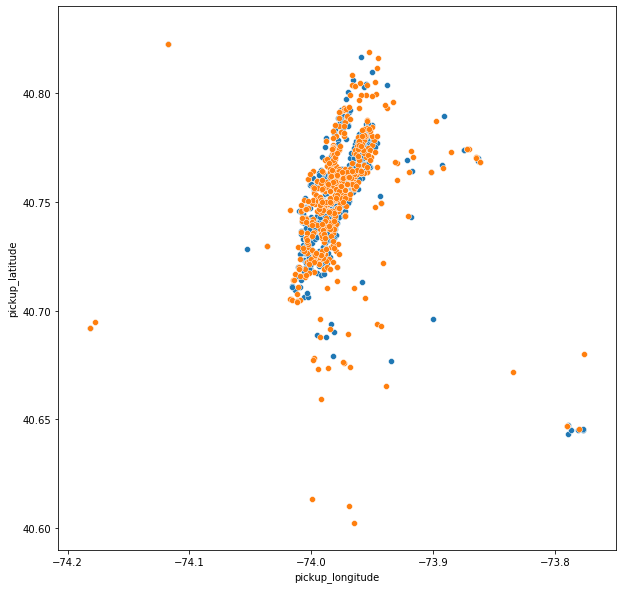

In [61]:
plt.figure(figsize = (10, 10))
sns.scatterplot(data["pickup_longitude"][:500], data["pickup_latitude"][:500])
sns.scatterplot(data["dropoff_longitude"][:500], data["dropoff_latitude"][:500])

In [62]:
data.isna().sum(), data.isnull().sum()

(key                  0
 pickup_datetime      0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 fare_amount          0
 dtype: int64,
 key                  0
 pickup_datetime      0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    0
 dropoff_latitude     0
 passenger_count      0
 fare_amount          0
 dtype: int64)

<h4>Ingeniería de Características</h4>

In [63]:
#Distancia entre dos puntos (Métrica de Haversine)
# two ways 
# 1  : Using the package

#from haversine import haversine
#origin = (39.50, 98.35)
#paris = (48.8567, 2.3508)
#haversine(origin, paris, miles=False) # return the distance in km

# 2 def a function

def radian(sexag):
    return sexag*(pi/180.0)

def Haversine(lat1,lon1,lat2,lon2):
    if (lat1 == lat2 and lon1 == lon2):
        return 0.0001 # por mientras
    diffLat = radian(lat2-lat1)
    diffLon = radian(lon2-lon1)
    h = sin(diffLat/2) ** 2 + cos(radian(lat1))*cos(radian(lat2))*(sin(diffLon/2)**2)
    dKm = 2.0 * 6371.345 * asin(sqrt(h))
    return dKm 

#print(Haversine(39.50, 98.35, 48.8567, 2.3508))

data['distance'] = data.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,distance
count,962031.000000,962031.000000,962031.000000,962031.000000,962031.000000,962031.000000,962031.000000
mean,-73.975711,40.750461,-73.975185,40.749985,1.688708,11.128906,3.221792
std,0.034311,0.026428,0.033578,0.028919,1.304332,9.241900,3.436865
min,-74.251882,40.498677,-74.252315,40.499350,1.000000,2.000000,0.000084
25%,-73.992375,40.736385,-73.991720,40.735227,1.000000,6.000000,1.247991
50%,-73.982164,40.753070,-73.980867,40.753355,1.000000,8.500000,2.131330
75%,-73.968653,40.767124,-73.966321,40.767647,2.000000,12.500000,3.819535
max,-73.634925,40.825075,-73.631115,40.825075,6.000000,200.000000,39.885880


<h4> Definición del modelo a entrenar </h4>

Intercepto: 3.426
Coeficientes: 2.370
CPU times: user 121 ms, sys: 20 ms, total: 141 ms
Wall time: 270 ms


In [68]:
modelo = LinearRegression()

predictors = ['distance']
salida = 'fare_amount'

X = data[predictors]
y = data[salida]


modelo.fit(X, y)

# Imprime el b y lso coeficientes
print(f'Intercepto: {modelo.intercept_:.3f}')
print(f'Coeficientes: {modelo.coef_[0]:.3f}')

Intercepto: 3.574
Coeficientes: 2.345


In [80]:
# comparo el valor predicho de todos los puntos dados con el calculado
fitted = modelo.predict(data[predictors])
residuals = data[salida] - fitted

In [ ]:
ax = data.plot.scatter(x="distance", y="fare_amount", figsize=(16, 16))
ax.scatter(data.distance, data.fare_amount, alpha=0.5, c='aqua')
ax.plot(data.distance, fitted, c="red")
"""
for x, y_actual, y_fitted in zip(data.distance, data.fare_amount, fitted):
    ax.plot((x, x), (y_actual, y_fitted), "--", color="C1")
"""    
plt.tight_layout()
plt.show()

In [ ]:
# Todavia X_test no es similar a data modificada
#modelo.score(X_test, y_test)

## Metrics

In [73]:
# datos de entrenamiento y el ajustado
r2score = r2_score(data[salida], fitted)
mse = mean_squared_error(data[salida], fitted)
rmse = sqrt(mean_squared_error(data[salida], fitted))

print("MSE", mse)
print("RMSE",rmse)
print("R2", r2score)

MSE 20.460672874058247
RMSE 4.52334752965746
R2 0.7604491090078394


In [74]:
#Para probar X test se deben  aplicar simirales transformaciones
X_test['distance'] = X_test.apply(lambda row: Haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)




In [83]:
X_test =X_test.fillna(0)
y_predicted = modelo.predict(X_test[predictors])
residuals = y_test - y_predicted

In [86]:
r2score = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
rmse = sqrt(mean_squared_error(y_test, y_predicted))

print("MSE", mse)
print("RMSE",rmse)
print("R2", r2score)

MSE 755294.6851851271
RMSE 869.0769155748685
R2 -7774.361041257256


In [ ]:
# F con esas metricas v':